## Fase 1 do projeto MD-TP4

#### Passo 1

Aqui somente carregamos os dados para dataframes pandas

In [1]:
# Import all the data from the file "data/"
from pandas import read_csv

data_dir = None
dataset_names = None
    
def load_csv(file, data_dir="data"):
    return read_csv(data_dir + "/" + file)

def load_all(dfNamesList):
    global data_dir, dataset_names
    data_dir = "data"
    
    fundamentals = load_csv("fundamentals.csv")
    prices = load_csv("prices.csv")
    prices_split_adjusted = load_csv("prices-split-adjusted.csv")
    securities = load_csv("securities.csv")

    nameToDf = {"fundamentals": fundamentals,
               "prices": prices,
               "prices_split_adjusted": prices_split_adjusted,
               "securities": securities}
    
    if dfNamesList == []:
        raise AttributeError("Empty names list.")
    
    dataset_names = dfNamesList
    if len(dfNamesList) == 1:
        return nameToDf[dfNamesList[0]]
    else:
        return [nameToDf[name] for name in dfNamesList]
    
pricesDf = load_all(["prices"]) # Only deal with prices for now

# Define this list so to be used later if needed
dfList = [pricesDf]

#### Passo 2

Lidando com valores invalidos ou faltantes (objetivo principal deste passo)

Alem disso, foi necessario formatar os dados. DEcidi formatar os dados antes
de testar por valores faltantes, para garantir que a formatacao nao introduziu
nenhum.

O resultado deste passo eh um dataset que pode ser usado no passo 3 e em diante
para realizar analises e exploracao.

In [2]:
# Realizar formatacao basica dos dados
# colunas a serem formatadas = ["date"]

from pandas import to_datetime
from numpy import int64

# Defined in format_date
minDate = None
maxDate = None

def date_to_day(dtObj):
    nanosToS = lambda nano: nano / 1e9
    sToHours = lambda s: s / 3600
    hoursToDays = lambda h: h / 24

    # Composition
    nanosToDays = lambda nanos: hoursToDays(sToHours(nanosToS(nanos)))
    
    return nanosToDays(dtObj.value)

# Convert every date in the given series to have base on the minumum date
# That is to say that the minimum date will be day 0, for example
def normalize_date(dateSeries, minDate):
    return dateSeries - minDate

def format_date(df, dateCol="date"):
    df[dateCol] = to_datetime(pricesDf[dateCol])

    # Guardar estes valores, caso seja necessario depois
    global minDate, maxDate
    minDate = df[dateCol].min()
    maxDate = df[dateCol].max()
    
    # Convert every date to a day by day format
    df[dateCol] = normalize_date(df[dateCol], minDate)
    
    df[dateCol] = df[dateCol].apply(date_to_day).astype(int64)

format_date(pricesDf)

In [3]:
# Checks for Nan, None, np.NaN
def guarantee_no_nan(df):
    assert(df.isna().values.sum() == 0)

def check_all_dfs_no_nan(dfsList):
    for df in dfsList:
        guarantee_no_nan(df)

check_all_dfs_no_nan(dfList)

#### Passo 3

Listagem de estatísticas básicas sobre os dados.

- Variância
- Curtose
- Assimetria

In [4]:
numericalData = pricesDf.drop("symbol", axis=1)

In [5]:
# Variância
numericalData.var()

date      5.456742e+05
open      7.005000e+03
close     7.003964e+03
low       6.868646e+03
high      7.134421e+03
volume    1.561171e+14
dtype: float64

In [6]:
# Curtose
from scipy.stats import kurtosis
print("Curtose por coluna:")
print(list(numericalData.columns))
print(kurtosis(numericalData, fisher=True))

Curtose por coluna:
['date', 'open', 'close', 'low', 'high', 'volume']
[ -1.20238617  66.3303002   66.27563621  66.41904422  66.16620239
 326.06556574]


In [7]:
# Assimetria
from scipy.stats import skew
print("Assimetria por coluna:")
print(list(numericalData.columns))
print(skew(numericalData))

Assimetria por coluna:
['date', 'open', 'close', 'low', 'high', 'volume']
[-0.03325066  6.65684851  6.65371765  6.66069158  6.6488655  13.13272314]


#### Passo 4

Mostrar visualizações interessantes dos dados. Tentar:

- Histograma
- Gráficos de correlação

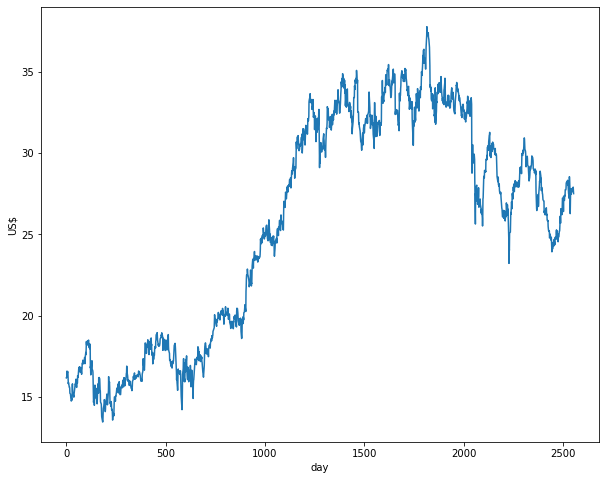

In [8]:
from matplotlib import pyplot as plt

# Plot data for FOX company

foxData = pricesDf[pricesDf["symbol"] == 'FOX']

foxTimes = foxData["date"]
foxPrices = foxData["open"]

plt.figure(1, figsize=(10, 8))
plt.plot(foxTimes, foxPrices)
plt.ylabel("US$")
plt.xlabel("day")
plt.show()

# Need to extend this idea, to include all of the companies.
# Also, maybe it would be nice to use some technique to integrate
# features like open/close into one.